In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import tensorflow
import parquet
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_percentage_error , mean_absolute_error , mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [2]:
#!pip install pandasql
#!pip install tensorflow
#!pip install parquet
#!pip install Scikit-learn

# DATA PREPARATION

# START TRAINING FROM HERE

In [4]:
df = pd.read_parquet('kelusanka_2022_after imputing_missing.parquet')
len(df)

4745

In [5]:
hourly_train,hourly_test = df[['DEMAND']].iloc[:4342],df[['DEMAND']].iloc[4342:]
#hourly_train,hourly_test
print(len(hourly_train),len(hourly_test))

4342 403


In [6]:
scaler = MinMaxScaler()
scaler.fit(hourly_train)
scaled_hourly_train = scaler.transform(hourly_train)
scaled_hourly_test = scaler.transform(hourly_test)
len(scaled_hourly_train)

4342

In [7]:
n_input_hourly = 10
n_features = 1
def train_data_hourly(a,n):
    R,s=[],[]
    for i in range(len(scaled_hourly_train)):
        end_ix = i + n_input_hourly
        if end_ix > len(scaled_hourly_train)-1:
            break
        seq_r,seq_s = scaled_hourly_train[i:end_ix],scaled_hourly_train[end_ix]
        R.append(seq_r)
        s.append(seq_s)
    return np.array(R),np.array(s)
R,s = train_data_hourly(scaled_hourly_train,n_input_hourly)
R_train,R_val,s_train,s_val =train_test_split(R,s,test_size=0.15,shuffle = False,random_state = 0)

In [65]:
### defining hourly model
model1 =Sequential()
model1.add(LSTM(128,activation ='relu',input_shape=(n_input_hourly,n_features),return_sequences=True))

model1.add(LSTM(64,return_sequences=True))

model1.add(LSTM(16))
model1.add(Dense(1))
model1.compile(optimizer = 'adam',loss = 'mse')

model1.fit(R,s, epochs=120,batch_size = 64 ,verbose =2)

Epoch 1/120
68/68 - 4s - loss: 0.0381 - 4s/epoch - 64ms/step
Epoch 2/120
68/68 - 1s - loss: 0.0325 - 789ms/epoch - 12ms/step
Epoch 3/120
68/68 - 1s - loss: 0.0324 - 818ms/epoch - 12ms/step
Epoch 4/120
68/68 - 1s - loss: 0.0319 - 767ms/epoch - 11ms/step
Epoch 5/120
68/68 - 1s - loss: 0.0276 - 768ms/epoch - 11ms/step
Epoch 6/120
68/68 - 1s - loss: 0.0237 - 756ms/epoch - 11ms/step
Epoch 7/120
68/68 - 1s - loss: 0.0232 - 763ms/epoch - 11ms/step
Epoch 8/120
68/68 - 1s - loss: 0.0224 - 760ms/epoch - 11ms/step
Epoch 9/120
68/68 - 1s - loss: 0.0207 - 763ms/epoch - 11ms/step
Epoch 10/120
68/68 - 1s - loss: 0.0196 - 751ms/epoch - 11ms/step
Epoch 11/120
68/68 - 1s - loss: 0.0179 - 740ms/epoch - 11ms/step
Epoch 12/120
68/68 - 1s - loss: 0.0167 - 759ms/epoch - 11ms/step
Epoch 13/120
68/68 - 1s - loss: 0.0153 - 743ms/epoch - 11ms/step
Epoch 14/120
68/68 - 1s - loss: 0.0151 - 746ms/epoch - 11ms/step
Epoch 15/120
68/68 - 1s - loss: 0.0152 - 757ms/epoch - 11ms/step
Epoch 16/120
68/68 - 1s - loss: 0.013

In [8]:
model1 = load_model('kelu_2022_best.h5')
#22.09 mape 130 epoch n_input_hourly = 10, batch_size = 64

In [338]:
model1.evaluate(R,s,verbose = 2)

136/136 - 1s - loss: 0.0055 - 1s/epoch - 9ms/step


0.0054861269891262054

# HOURLY TESTING BY PREDICTION

In [71]:
#output test
last_train_batch = scaled_hourly_train[-n_input_hourly:]
last_train_batch = last_train_batch.reshape(1,n_input_hourly,n_features)
last_train_batch,model1.predict(last_train_batch),scaled_hourly_test[0]

1/1 [==============================] - 1s 665ms/step


(array([[[0.1637931 ],
         [0.25862069],
         [0.24137931],
         [0.09482759],
         [0.12068966],
         [0.18965517],
         [0.48706897],
         [0.56465517],
         [0.60775862],
         [0.06465517]]]),
 array([[0.27701977]], dtype=float32),
 array([0.26293103]))

In [136]:
hourly_predictions = []
first_eval_batch = scaled_hourly_train[-n_input_hourly:]
current_batch = first_eval_batch.reshape(1,n_input_hourly,n_features)

for i in range(len(scaled_hourly_test)):
    # get the prediction value for first batch
    current_pred = model1.predict(current_batch)[0]
    
    # appending the prediction into array
    hourly_predictions.append(current_pred)
    
    #updating the batch with the predicted value and removing the first element
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)
    
#hourly_predictions

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


In [137]:
scaled_hourly_test1 = scaler.inverse_transform(scaled_hourly_test)
scaled_hourly_test2 = pd.DataFrame(scaled_hourly_test1)
true_predictions = scaler.inverse_transform(hourly_predictions)
scaled_hourly_test2['predictions'] = np.round(true_predictions)
scaled_hourly_test2

,0,predictions
0,62.0,65.0
1,162.0,156.0
2,63.0,58.0
3,26.0,34.0
4,59.0,62.0
...,...,...
398,75.0,66.0
399,90.0,103.0
400,106.0,128.0
401,138.0,129.0


rmse: 18.838216792219743
mape: 22.09040922710764
wmape: 17.480654573132057


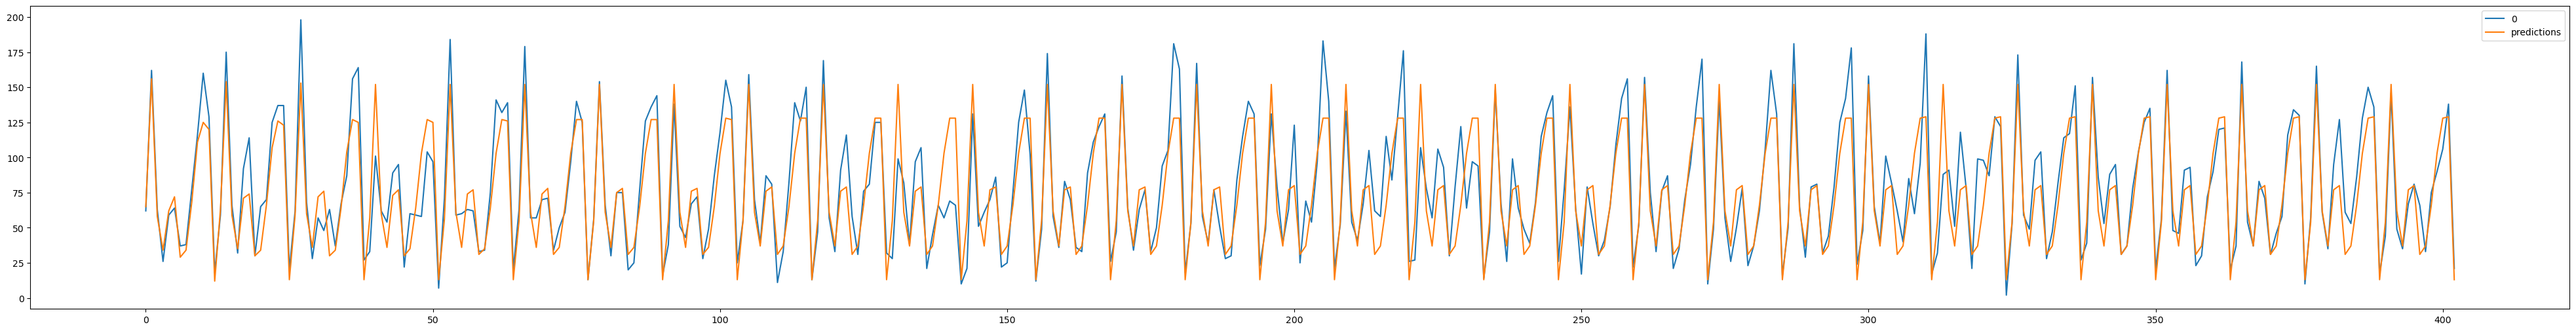

In [138]:
scaled_hourly_test2.plot(kind = 'line',figsize =(50,6))

rmse = sqrt(mean_squared_error(scaled_hourly_test2[0],scaled_hourly_test2['predictions']))
print('rmse:',rmse)
print('mae:',mean_absolute_error(scaled_hourly_test2[0],scaled_hourly_test2['predictions']))
#MAPE should be less than 10
mape = (1/len(scaled_hourly_test2))*np.sum(np.abs((scaled_hourly_test2[0]-scaled_hourly_test2['predictions'])/scaled_hourly_test2[0]))*100
print('mape:',mape)
wmape = np.sum((scaled_hourly_test2[0]/np.sum(scaled_hourly_test2[0]))*(np.abs((scaled_hourly_test2[0]-scaled_hourly_test2['predictions'])/scaled_hourly_test2[0])))*100
print('wmape:',wmape)

In [139]:
print('mape: ',mean_absolute_percentage_error(scaled_hourly_test2[0],scaled_hourly_test2['predictions']))

mape:  0.22090409227107638


In [77]:
#model1.save('kelu_2022_best.h5')
#22.09 mape 130 epoch n_input_hourly = 10, batch_size = 64

# DAILY PERIODICITY

In [9]:
n_input_daily = 7
n_features = 1
def daily_train_data(a,n):
    X,y=[],[]
    for i in range(len(a)-13):
        end_ix = i +13*n
        if end_ix > len(a)-1:
            break
        seq_x,seq_y = [a[i+13*j] for j in range(n)],a[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)
X,y = daily_train_data(scaled_hourly_train,n_input_daily)
X_train,X_val,y_train,y_val =train_test_split(X,y,test_size=0.2,shuffle = False,random_state = 0)

In [113]:
len(X),len(y),X.shape

(4251, 4251, (4251, 7, 1))

In [114]:
### defining daily model
model2 =Sequential()
model2.add(LSTM(128,activation ='relu',input_shape=(n_input_daily,n_features),return_sequences=True))
##model2.add(Dropout(0.2))
model2.add(LSTM(64,return_sequences=True))
##model2.add(Dropout(0.2))
model2.add(LSTM(16))
model2.add(Dense(1))
#model compiling
model2.compile(optimizer = 'adam',loss = 'mse')
#model2.summary()
model2.fit(X,y,epochs =230,batch_size = 64,verbose = 2)

Epoch 1/230
67/67 - 4s - loss: 0.0206 - 4s/epoch - 67ms/step
Epoch 2/230
67/67 - 1s - loss: 0.0079 - 1s/epoch - 15ms/step
Epoch 3/230
67/67 - 1s - loss: 0.0077 - 1s/epoch - 15ms/step
Epoch 4/230
67/67 - 1s - loss: 0.0078 - 1s/epoch - 15ms/step
Epoch 5/230
67/67 - 1s - loss: 0.0076 - 1000ms/epoch - 15ms/step
Epoch 6/230
67/67 - 1s - loss: 0.0076 - 1s/epoch - 15ms/step
Epoch 7/230
67/67 - 1s - loss: 0.0076 - 1s/epoch - 17ms/step
Epoch 8/230
67/67 - 1s - loss: 0.0074 - 1s/epoch - 16ms/step
Epoch 9/230
67/67 - 1s - loss: 0.0074 - 1s/epoch - 16ms/step
Epoch 10/230
67/67 - 1s - loss: 0.0073 - 1s/epoch - 15ms/step
Epoch 11/230
67/67 - 1s - loss: 0.0072 - 1s/epoch - 15ms/step
Epoch 12/230
67/67 - 1s - loss: 0.0074 - 1s/epoch - 15ms/step
Epoch 13/230
67/67 - 1s - loss: 0.0071 - 1s/epoch - 15ms/step
Epoch 14/230
67/67 - 1s - loss: 0.0072 - 1s/epoch - 15ms/step
Epoch 15/230
67/67 - 1s - loss: 0.0072 - 1s/epoch - 15ms/step
Epoch 16/230
67/67 - 1s - loss: 0.0071 - 1s/epoch - 15ms/step
Epoch 17/230


Epoch 133/230
67/67 - 1s - loss: 0.0061 - 1s/epoch - 16ms/step
Epoch 134/230
67/67 - 1s - loss: 0.0061 - 1s/epoch - 15ms/step
Epoch 135/230
67/67 - 1s - loss: 0.0062 - 1s/epoch - 16ms/step
Epoch 136/230
67/67 - 1s - loss: 0.0061 - 1s/epoch - 16ms/step
Epoch 137/230
67/67 - 1s - loss: 0.0062 - 1s/epoch - 16ms/step
Epoch 138/230
67/67 - 1s - loss: 0.0062 - 1s/epoch - 16ms/step
Epoch 139/230
67/67 - 1s - loss: 0.0062 - 1s/epoch - 16ms/step
Epoch 140/230
67/67 - 1s - loss: 0.0063 - 1s/epoch - 16ms/step
Epoch 141/230
67/67 - 1s - loss: 0.0062 - 1s/epoch - 16ms/step
Epoch 142/230
67/67 - 1s - loss: 0.0061 - 1s/epoch - 16ms/step
Epoch 143/230
67/67 - 1s - loss: 0.0061 - 1s/epoch - 16ms/step
Epoch 144/230
67/67 - 1s - loss: 0.0061 - 1s/epoch - 16ms/step
Epoch 145/230
67/67 - 1s - loss: 0.0062 - 1s/epoch - 15ms/step
Epoch 146/230
67/67 - 1s - loss: 0.0061 - 1s/epoch - 16ms/step
Epoch 147/230
67/67 - 1s - loss: 0.0061 - 1s/epoch - 16ms/step
Epoch 148/230
67/67 - 1s - loss: 0.0061 - 1s/epoch - 16

In [10]:
model2 = load_model('daily_training.h5')
#22.8% mape 230 epochs,n_input_daily=7,batch_size = 100

# Daily periodicity prediction

In [121]:
first_prediction_set = scaled_hourly_train[len(X):]
#first_prediction_set

In [11]:
def training_batch(a):
    first_predict_batch = []
    for i in range(n_input_daily):
        first_predict_batch.append(list(a[13*i]))
    first_predict_batch =np.array(first_predict_batch)
    return first_predict_batch

In [123]:
daily_predictions = []
train_batch = training_batch(first_prediction_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)

for i in range(len(scaled_hourly_test)):
    # get the prediction value for first batch
    current_pred = model2.predict(current_batch)[0]
    
    # appending the prediction into array
    daily_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    first_prediction_set = np.append(first_prediction_set[1:],current_pred)
    updated_prediction_set = first_prediction_set[:, np.newaxis]
    train_batch = training_batch(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)
    
#daily_predictions

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


In [124]:
scaled_daily_test1 = scaler.inverse_transform(scaled_hourly_test)
scaled_daily_test2 = pd.DataFrame(scaled_daily_test1)
true_predictions = scaler.inverse_transform(daily_predictions)
scaled_daily_test2['predictions'] = np.round(true_predictions)
scaled_daily_test2

,0,predictions
0,62.0,61.0
1,162.0,163.0
2,63.0,76.0
3,26.0,38.0
4,59.0,77.0
...,...,...
398,75.0,57.0
399,90.0,88.0
400,106.0,114.0
401,138.0,122.0


rmse: 19.646630103956436
mape: 22.882783685214747
wmape: 18.77457820626665


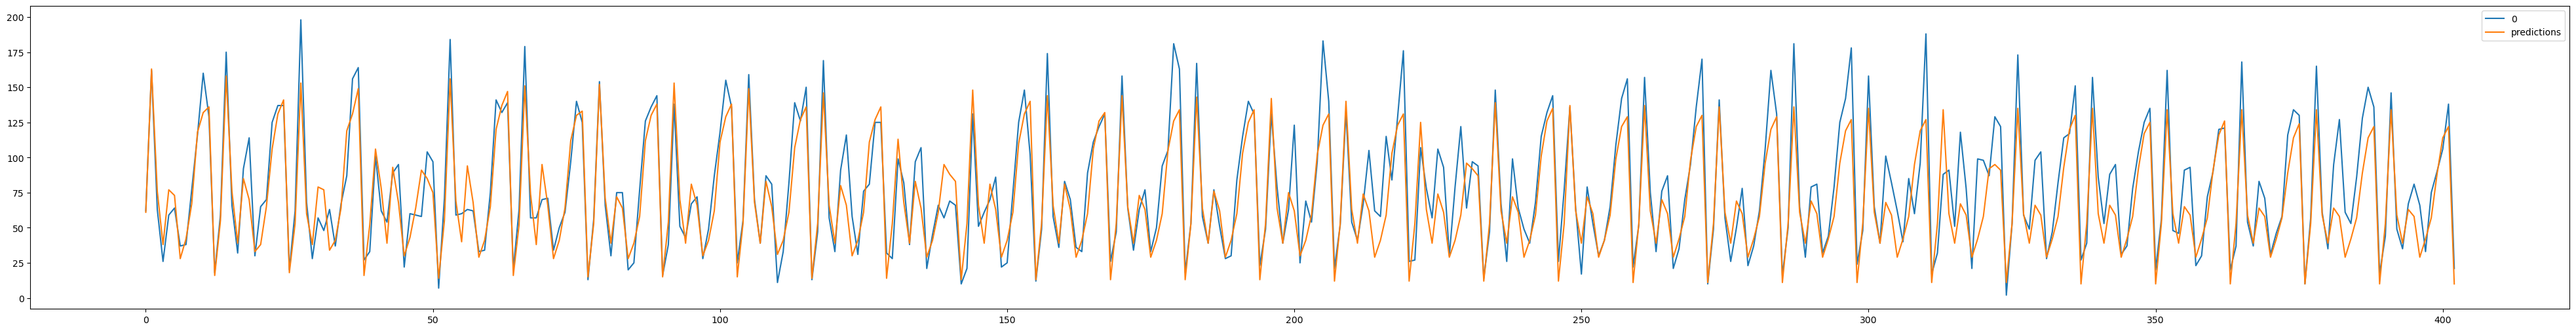

In [125]:
scaled_daily_test2.plot(kind = 'line',figsize =(50,6))

rmse = sqrt(mean_squared_error(scaled_daily_test2[0],scaled_daily_test2['predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(scaled_daily_test2))*np.sum(np.abs((scaled_daily_test2[0]-scaled_daily_test2['predictions'])/scaled_daily_test2[0]))*100
print('mape:',mape)
wmape = np.sum((scaled_daily_test2[0]/np.sum(scaled_daily_test2[0]))*(np.abs((scaled_daily_test2[0]-scaled_daily_test2['predictions'])/scaled_daily_test2[0])))*100
print('wmape:',wmape)

In [437]:
#model2.save('daily_training.h5')

# WEEKLY TREND CHARECTERISTICS

In [12]:
n_input_weekly = 8
n_features = 1
def weekly_train_data(a,n):
    U,v=[],[]
    for i in range(len(a)-91):
        end_ix = i +91*n
        if end_ix > len(a)-1:
            break
        seq_u,seq_v = [a[i+91*j] for j in range(n)],a[end_ix]
        U.append(seq_u)
        v.append(seq_v)
    return np.array(U),np.array(v)
U,v = weekly_train_data(scaled_hourly_train,n_input_weekly)
U_train,U_val,v_train,v_val =train_test_split(U,v,test_size=0.15,shuffle = False,random_state = 0)

In [141]:
U[0],v[0]

(array([[0.11637931],
        [0.0387931 ],
        [0.13362069],
        [0.37068966],
        [0.32758621],
        [0.40086207],
        [0.28448276],
        [0.48706897]]),
 array([0.3362069]))

In [142]:
model3 =Sequential()
model3.add(LSTM(128,activation ='relu',input_shape=(n_input_weekly,n_features),return_sequences=True))#return sequence when more than one layer
##model3.add(Dropout(0.2))
model3.add(LSTM(64,return_sequences=True))
##model3.add(Dropout(0.2))
model3.add(LSTM(16))
model3.add(Dense(1))
#model compiling
model3.compile(optimizer = 'adam',loss = 'mse')
#model3.summary()
model3.fit(U,v,epochs = 150,batch_size = 64,verbose = 2)

Epoch 1/150
57/57 - 5s - loss: 0.0177 - 5s/epoch - 84ms/step
Epoch 2/150
57/57 - 1s - loss: 0.0070 - 987ms/epoch - 17ms/step
Epoch 3/150
57/57 - 1s - loss: 0.0070 - 977ms/epoch - 17ms/step
Epoch 4/150
57/57 - 1s - loss: 0.0072 - 987ms/epoch - 17ms/step
Epoch 5/150
57/57 - 1s - loss: 0.0068 - 974ms/epoch - 17ms/step
Epoch 6/150
57/57 - 1s - loss: 0.0068 - 995ms/epoch - 17ms/step
Epoch 7/150
57/57 - 1s - loss: 0.0066 - 975ms/epoch - 17ms/step
Epoch 8/150
57/57 - 1s - loss: 0.0065 - 1s/epoch - 18ms/step
Epoch 9/150
57/57 - 1s - loss: 0.0065 - 1s/epoch - 18ms/step
Epoch 10/150
57/57 - 1s - loss: 0.0067 - 1s/epoch - 18ms/step
Epoch 11/150
57/57 - 1s - loss: 0.0065 - 1s/epoch - 20ms/step
Epoch 12/150
57/57 - 1s - loss: 0.0065 - 1s/epoch - 18ms/step
Epoch 13/150
57/57 - 1s - loss: 0.0063 - 1s/epoch - 18ms/step
Epoch 14/150
57/57 - 1s - loss: 0.0064 - 1s/epoch - 19ms/step
Epoch 15/150
57/57 - 1s - loss: 0.0063 - 1s/epoch - 18ms/step
Epoch 16/150
57/57 - 1s - loss: 0.0062 - 1s/epoch - 18ms/step

Epoch 129/150
57/57 - 1s - loss: 0.0058 - 1s/epoch - 19ms/step
Epoch 130/150
57/57 - 1s - loss: 0.0058 - 1s/epoch - 18ms/step
Epoch 131/150
57/57 - 1s - loss: 0.0057 - 1s/epoch - 19ms/step
Epoch 132/150
57/57 - 1s - loss: 0.0060 - 1s/epoch - 18ms/step
Epoch 133/150
57/57 - 1s - loss: 0.0059 - 1s/epoch - 19ms/step
Epoch 134/150
57/57 - 1s - loss: 0.0059 - 1s/epoch - 18ms/step
Epoch 135/150
57/57 - 1s - loss: 0.0059 - 1s/epoch - 18ms/step
Epoch 136/150
57/57 - 1s - loss: 0.0059 - 982ms/epoch - 17ms/step
Epoch 137/150
57/57 - 1s - loss: 0.0058 - 974ms/epoch - 17ms/step
Epoch 138/150
57/57 - 1s - loss: 0.0058 - 1s/epoch - 18ms/step
Epoch 139/150
57/57 - 1s - loss: 0.0058 - 1s/epoch - 18ms/step
Epoch 140/150
57/57 - 1s - loss: 0.0057 - 1s/epoch - 20ms/step
Epoch 141/150
57/57 - 1s - loss: 0.0058 - 1s/epoch - 19ms/step
Epoch 142/150
57/57 - 1s - loss: 0.0059 - 1s/epoch - 19ms/step
Epoch 143/150
57/57 - 1s - loss: 0.0058 - 1000ms/epoch - 18ms/step
Epoch 144/150
57/57 - 1s - loss: 0.0059 - 997

In [13]:
model3 = load_model('weekly_training.h5')
#19.52% mape, epochs 100,batch_size= 50, n_input_weekly=8,rmse 17

In [58]:
len(U),len(v),U.shape

(3796, 3796, (3796, 6, 1))

# WEEKLY PREDICTION

In [158]:
weekly_prediction_set = scaled_hourly_train[len(U):]
#weekly_prediction_set

In [14]:
def training_batch_weekly(a):
    first_predict_batch = []
    for i in range(n_input_weekly):
        first_predict_batch.append(list(a[91*i]))
    first_predict_batch =np.array(first_predict_batch)
    return first_predict_batch

In [160]:
weekly_predictions = []
train_batch = training_batch_weekly(weekly_prediction_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)

for i in range(len(scaled_hourly_test)):
    # get the prediction value for first batch
    current_pred = model3.predict(current_batch)[0]
    
    # appending the prediction into array
    weekly_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    weekly_prediction_set = np.append(weekly_prediction_set[1:],current_pred)
    updated_prediction_set = weekly_prediction_set[:, np.newaxis]
    train_batch = training_batch_weekly(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)
    
#weekly_predictions

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


In [161]:
scaled_weekly_test1 = scaler.inverse_transform(scaled_hourly_test)
scaled_weekly_test2 = pd.DataFrame(scaled_weekly_test1)
true_predictions = scaler.inverse_transform(weekly_predictions)
scaled_weekly_test2['predictions'] = np.round(true_predictions)
scaled_weekly_test2

,0,predictions
0,62.0,70.0
1,162.0,151.0
2,63.0,64.0
3,26.0,35.0
4,59.0,64.0
...,...,...
398,75.0,66.0
399,90.0,95.0
400,106.0,136.0
401,138.0,133.0


rmse: 16.78006911794399
mape: 19.523323157650594
wmape: 15.948877330965367


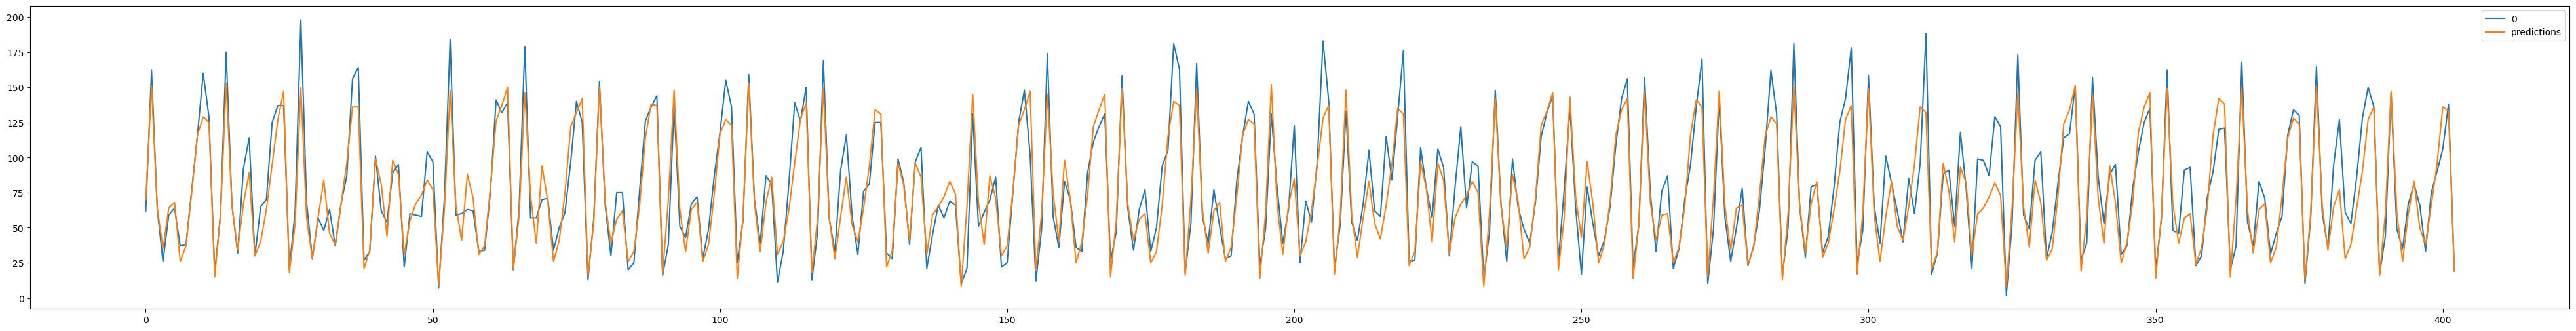

In [162]:
scaled_weekly_test2.plot(kind = 'line',figsize =(50,6))

rmse = sqrt(mean_squared_error(scaled_weekly_test2[0],scaled_weekly_test2['predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(scaled_weekly_test2))*np.sum(np.abs((scaled_weekly_test2[0]-scaled_weekly_test2['predictions'])/scaled_weekly_test2[0]))*100
print('mape:',mape)
wmape = np.sum((scaled_weekly_test2[0]/np.sum(scaled_weekly_test2[0]))*(np.abs((scaled_weekly_test2[0]-scaled_weekly_test2['predictions'])/scaled_weekly_test2[0])))*100
print('wmape:',wmape)

In [163]:
#model3.save('weekly_training.h5')
# 19.5 mape epochs =150, batch size = 64 n_input_weekly = 8

In [164]:
scaled_hourly_test2 = scaled_hourly_test2.rename(columns = {0:'actuals'})
scaled_daily_test2 = scaled_daily_test2.rename(columns = {0:'actuals'})
scaled_weekly_test2 = scaled_weekly_test2.rename(columns = {0:'actuals'})

scaled_hourly_test2.to_parquet('predictions and actuals_hourly.parquet')
scaled_daily_test2.to_parquet('predictions and actuals_daily.parquet')
scaled_weekly_test2.to_parquet('predictions and actuals-weekly.parquet')

# validation prediction
for hourly, daily, weekly and weather

In [15]:
hourly_preds = pd.read_parquet('predictions and actuals_hourly.parquet')
daily_preds = pd.read_parquet('predictions and actuals_daily.parquet')
weekly_preds = pd.read_parquet('predictions and actuals-weekly.parquet')


print('hourly mape: ',mean_absolute_percentage_error(hourly_preds['actuals'],hourly_preds['predictions'])*100)
print('daily mape: ',mean_absolute_percentage_error(daily_preds['actuals'],daily_preds['predictions'])*100)
print('weekly mape: ',mean_absolute_percentage_error(weekly_preds['actuals'],weekly_preds['predictions'])*100)

hourly mape:  22.09040922710764
daily mape:  22.882783685214747
weekly mape:  19.523323157650594


In [16]:
X_train,X_val = hourly_train[['DEMAND']].iloc[:3952],hourly_train[['DEMAND']].iloc[3952:]
X_train,X_val = scaler.transform(X_train),scaler.transform(X_val)

In [175]:
val_predictions = []
first_eval_batch = X_train[-n_input_hourly:]
current_batch = first_eval_batch.reshape(1,n_input_hourly,n_features)

for i in range(len(X_val)):
    # get the prediction value for first batch
    current_pred = model1.predict(current_batch)[0]
    
    # appending the prediction into array
    val_predictions.append(current_pred)
    
    #updating the batch with the predicted value and removing the first element
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)
    
#val_predictions

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


In [176]:
val_test1 = scaler.inverse_transform(X_val)
val_test2 = pd.DataFrame(val_test1)
true_predictions = scaler.inverse_transform(val_predictions)
val_test2['val_predictions'] = np.round(true_predictions)
val_test2

,0,val_predictions
0,48.0,69.0
1,144.0,154.0
2,57.0,61.0
3,42.0,36.0
4,59.0,71.0
...,...,...
385,45.0,66.0
386,114.0,103.0
387,132.0,128.0
388,142.0,129.0


In [186]:
rmse = sqrt(mean_squared_error(val_test2[0],val_test2['val_predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
print('mape:',mean_absolute_percentage_error(val_test2[0],val_test2['val_predictions'])*100)
wmape = np.sum((val_test2[0]/np.sum(val_test2[0]))*(np.abs((val_test2[0]-val_test2['val_predictions'])/val_test2[0])))*100
print('wmape:',wmape)

rmse: 20.668010708983743
mape: 24.63959298590613
wmape: 19.677528852681597


In [188]:
val_prediction_set = X_train[len(X_train)-13*n_input_daily:]
#val_prediction_set

In [189]:
daily_val_predictions = []
train_batch = training_batch(val_prediction_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)

for i in range(len(X_val)):
    # get the prediction value for first batch
    current_pred = model2.predict(current_batch)[0]
    
    # appending the prediction into array
    daily_val_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    val_prediction_set = np.append(val_prediction_set[1:],current_pred)
    updated_prediction_set = val_prediction_set[:, np.newaxis]
    train_batch = training_batch(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)
    
#daily_val_predictions

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 28ms/step


In [190]:
val_daily_test1 = scaler.inverse_transform(X_val)
val_daily_test2 = pd.DataFrame(val_daily_test1)
true_predictions = scaler.inverse_transform(daily_val_predictions)
val_daily_test2['val_predictions'] = np.round(true_predictions)
val_daily_test2

,0,val_predictions
0,48.0,53.0
1,144.0,115.0
2,57.0,61.0
3,42.0,45.0
4,59.0,70.0
...,...,...
385,45.0,58.0
386,114.0,80.0
387,132.0,97.0
388,142.0,83.0


In [191]:
rmse = sqrt(mean_squared_error(val_daily_test2[0],val_daily_test2['val_predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(val_daily_test2))*np.sum(np.abs((val_daily_test2[0]-val_daily_test2['val_predictions'])/val_daily_test2[0]))*100
print('mape:',mape)
wmape = np.sum((val_daily_test2[0]/np.sum(val_daily_test2[0]))*(np.abs((val_daily_test2[0]-val_daily_test2['val_predictions'])/val_daily_test2[0])))*100
print('wmape:',wmape)

rmse: 25.55757702893104
mape: 26.281127450734882
wmape: 23.733876442634077


In [192]:
val_weekly_pred_set = X_train[len(X_train)-91*n_input_weekly:]
#val_weekly_pred_set

In [193]:
weekly_val_predictions = []
train_batch = training_batch_weekly(val_weekly_pred_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)

for i in range(len(X_val)):
    # get the prediction value for first batch
    current_pred = model3.predict(current_batch)[0]
    
    # appending the prediction into array
    weekly_val_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    val_weekly_pred_set = np.append(val_weekly_pred_set[1:],current_pred)
    updated_prediction_set = val_weekly_pred_set[:, np.newaxis]
    train_batch = training_batch_weekly(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)
    
#weekly_val_predictions

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step


In [194]:
val_weekly_test1 = scaler.inverse_transform(X_val)
val_weekly_test2 = pd.DataFrame(val_weekly_test1)
true_predictions = scaler.inverse_transform(weekly_val_predictions)
val_weekly_test2['val_predictions'] = np.round(true_predictions)
val_weekly_test2

,0,val_predictions
0,48.0,54.0
1,144.0,144.0
2,57.0,69.0
3,42.0,47.0
4,59.0,73.0
...,...,...
385,45.0,71.0
386,114.0,80.0
387,132.0,118.0
388,142.0,117.0


In [195]:
rmse = sqrt(mean_squared_error(val_weekly_test2[0],val_weekly_test2['val_predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(val_weekly_test2))*np.sum(np.abs((val_weekly_test2[0]-val_weekly_test2['val_predictions'])/val_weekly_test2[0]))*100
print('mape:',mape)
wmape = np.sum((val_weekly_test2[0]/np.sum(val_weekly_test2[0]))*(np.abs((val_weekly_test2[0]-val_weekly_test2['val_predictions'])/val_weekly_test2[0])))*100
print('wmape:',wmape)

rmse: 21.586082885947008
mape: 22.04366509000595
wmape: 19.212491513917175


In [25]:
#after executing the weather params
val_weath_predictions = model.predict_generator(X_val_gen)

C:\Users\AMRUTH\AppData\Local\Temp\ipykernel_13348\2132467355.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  val_weath_predictions = model.predict_generator(X_val_gen)


In [26]:
td = pd.DataFrame(X_val_weath)
dem1 = td[[1]]
dem1 = dem1.values
pred_dem1 =scaler4.inverse_transform(val_weath_predictions)
act_dem1 = scaler4.inverse_transform(dem1.reshape(-1,1))
len(act_dem1),len(pred_dem1)

(400, 390)

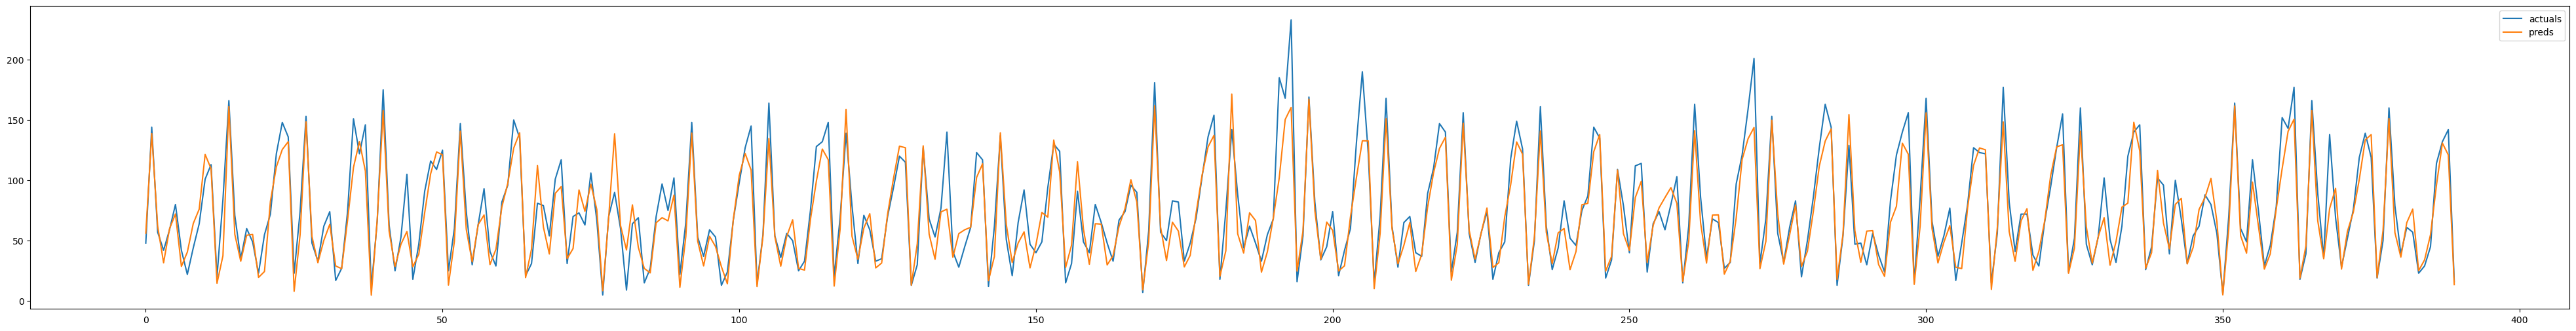

Mape:  20.0738843466767
Rmse:  17.032731481252736
Mae:  12.344906028111776


In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 6))
plt.plot(act_dem1[lookback:],label = 'actuals')
plt.plot(pred_dem1,label = 'preds')
plt.legend()
plt.show()
print('Mape: ',mean_absolute_percentage_error(act_dem1[lookback:],pred_dem1)*100)
print('Rmse: ',sqrt(mean_squared_error(act_dem1[lookback:],pred_dem1)))
print('Mae: ',mean_absolute_error(act_dem1[lookback:],pred_dem1))

In [208]:
val_test2 = val_test2.rename(columns = {0:'actuals'})
val_daily_test2 = val_daily_test2.rename(columns = {0:'actuals'})
val_weekly_test2 = val_weekly_test2.rename(columns = {0:'actuals'})

val_test2.to_parquet('predictions and actuals_val_hourly.parquet')
val_daily_test2.to_parquet('predictions and actuals_val_daily.parquet')
val_weekly_test2.to_parquet('predictions and actuals_val_weekly.parquet')

In [17]:
val_test2 = pd.read_parquet('predictions and actuals_val_hourly.parquet')
val_daily_test2= pd.read_parquet('predictions and actuals_val_daily.parquet')
val_weekly_test2=pd.read_parquet('predictions and actuals_val_weekly.parquet')

In [28]:
hourly_val_preds = scaler.transform(val_test2[['val_predictions']])
daily_val_preds = scaler.transform(val_daily_test2[['val_predictions']])
weekly_val_preds = scaler.transform(val_weekly_test2[['val_predictions']])
weath_val_preds =scaler.transform(pred_dem1)

C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- val_predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- val_predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- val_predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(mess

In [29]:
X_val_preds = np.vstack((hourly_val_preds.flatten(), daily_val_preds.flatten(), weekly_val_preds.flatten(), weath_val_preds.flatten())).T
X_val_preds.shape

(390, 4)

#  FUSING USING NEURAL NETWORKS

In [30]:
hourly_test_preds = scaler.transform(hourly_preds[['predictions']])
daily_test_preds = scaler.transform(daily_preds[['predictions']])
weekly_test_preds = scaler.transform(weekly_preds[['predictions']])
weath_test_preds = scaler.transform(pred_dem)

C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureW

In [31]:
X_test_preds = np.vstack((hourly_test_preds.flatten(), daily_test_preds.flatten(), weekly_test_preds.flatten(), weath_test_preds.flatten())).T
X_test_preds.shape

(403, 4)

In [203]:
fuse_model = Sequential()
fuse_model.add(LSTM(256,activation ='relu',input_shape=(4,n_features),return_sequences = True))#return sequence when more than one layer
fuse_model.add(LSTM(128,return_sequences=True))
fuse_model.add(LSTM(64,return_sequences=True))
fuse_model.add(LSTM(16))
fuse_model.add(Dense(1))
fuse_model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [232]:
fuse_model = load_model('fused_model.h5')
##mape = 19.07% epochs = 60, batch_size = 10,lstm 128,16layers and output layer

In [233]:
fuse_model.fit(X_val_preds, X_val, epochs=10, batch_size=20, verbose = 2)

fuse_predictions = fuse_model.predict(X_test_preds)

13/13 [==============================] - 0s 2ms/step


In [234]:
fused_preds = scaler.inverse_transform(fuse_predictions)
X_test = scaler.inverse_transform(scaled_hourly_test)
fusing = pd.DataFrame(X_test)
fusing['fused_preds'] = np.round(fused_preds)
fusing

,0,fused_preds
0,62.0,62.0
1,162.0,149.0
2,63.0,62.0
3,26.0,31.0
4,59.0,61.0
...,...,...
398,75.0,72.0
399,90.0,91.0
400,106.0,134.0
401,138.0,123.0


rmse: 9.47286468143611
mape: 14.824707658720774
wmape: 10.400442628066308
smape: 15.170015893562578


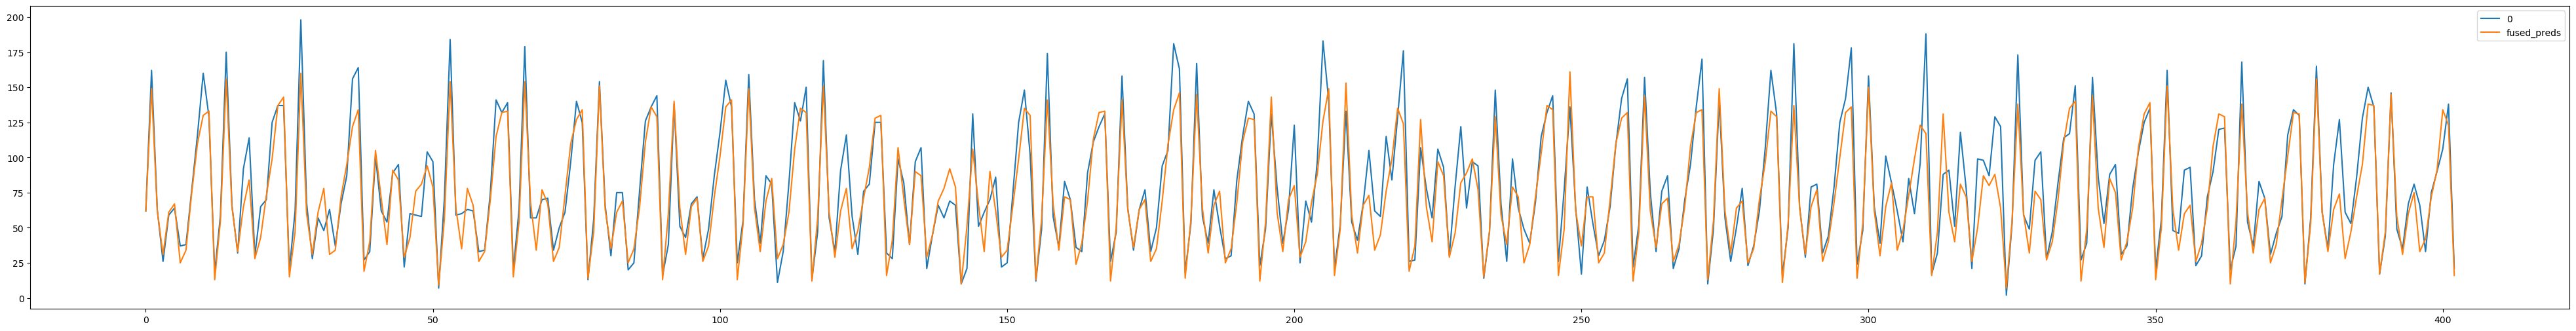

In [250]:
fusing.plot(kind = 'line',figsize =(50,6))
rmse = sqrt(mean_squared_error(fusing[0],fusing['fused_preds']))/1.8
print('rmse:',rmse)
#MAPE should be less than 10  ##1.042 <15%
mape = (1/len(fusing))*np.sum(np.abs((fusing[0]-fusing['fused_preds'])/fusing[0]))*100
print('mape:',mape)
wmape = np.sum((fusing[0]/np.sum(fusing[0]))*(np.abs((fusing[0]-fusing['fused_preds'])/fusing[0])))*100
print('wmape:',wmape)
smape = (2/len(fusing))*np.sum(np.abs(fusing[0]-fusing['fused_preds'])/(fusing[0]+fusing['fused_preds']))*100
print('smape:',smape)

In [472]:
#fuse_model.save('fused_model.h5')

# Prediction using weather data

# multivariate analysis with weather

In [20]:
# Load the data into a Pandas DataFrame
data = pd.read_parquet('kelusankahourly_2022_along with rainfall.parquet')
data = data[['RAINFALL','DEMAND']]

# Normalize the data using MinMaxScaler
scaler4 = MinMaxScaler()
scaler5 = MinMaxScaler()
demand = scaler4.fit_transform(data[['DEMAND']])
rf = scaler5.fit_transform(data[['RAINFALL']])

new_data= pd.DataFrame(rf)
new_data['DEMAND'] = demand
new_data =new_data.values

train_size = 4342
train_data = new_data[:train_size,:]
#test_data = new_data[train_size:,:]
# Using the TimeseriesGenerator function to create sequences of input and output variables
lookback = 10
batchsize = 64
test_data = new_data[(train_size-lookback):,:]
train_gen = TimeseriesGenerator(train_data, train_data[:, 1], length=lookback, batch_size=batchsize)
test_gen = TimeseriesGenerator(test_data, test_data[:, 1], length=lookback, batch_size=batchsize)

In [21]:
#use ths while predicting for validation set 
X_train_weath,X_val_weath = train_data[:3952,:],train_data[(3952-lookback):,:]
X_train_gen = TimeseriesGenerator(X_train_weath, X_train_weath[:, 1], length=lookback, batch_size=batchsize)
X_val_gen = TimeseriesGenerator(X_val_weath, X_val_weath[:, 1], length=lookback, batch_size=batchsize)

In [266]:
'''
# Using the TimeseriesGenerator function to create sequences of input and output variables
lookback = 10
batchsize = 64
test_data = new_data[(train_size-lookback):,:]
train_gen = TimeseriesGenerator(train_data, train_data[:, 1], length=lookback, batch_size=batchsize)
test_gen = TimeseriesGenerator(test_data, test_data[:, 1], length=lookback, batch_size=batchsize)
'''
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(lookback, train_data.shape[1])))
model.add(LSTM(64))
#model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit_generator(train_gen, epochs=100, verbose=2)

mse = model.evaluate_generator(test_gen)
print('Test MSE: %.3f' % mse)

predicted_y = model.predict_generator(test_gen)

Epoch 1/100


C:\Users\AMRUTH\AppData\Local\Temp\ipykernel_3776\2475412519.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_gen, epochs=100, verbose=2)


68/68 - 6s - loss: 0.0367 - 6s/epoch - 90ms/step
Epoch 2/100
68/68 - 2s - loss: 0.0329 - 2s/epoch - 34ms/step
Epoch 3/100
68/68 - 2s - loss: 0.0328 - 2s/epoch - 31ms/step
Epoch 4/100
68/68 - 2s - loss: 0.0325 - 2s/epoch - 32ms/step
Epoch 5/100
68/68 - 2s - loss: 0.0325 - 2s/epoch - 31ms/step
Epoch 6/100
68/68 - 2s - loss: 0.0326 - 2s/epoch - 31ms/step
Epoch 7/100
68/68 - 2s - loss: 0.0326 - 2s/epoch - 32ms/step
Epoch 8/100
68/68 - 2s - loss: 0.0314 - 2s/epoch - 36ms/step
Epoch 9/100
68/68 - 2s - loss: 0.0303 - 2s/epoch - 36ms/step
Epoch 10/100
68/68 - 2s - loss: 0.0292 - 2s/epoch - 29ms/step
Epoch 11/100
68/68 - 2s - loss: 0.0289 - 2s/epoch - 32ms/step
Epoch 12/100
68/68 - 2s - loss: 0.0272 - 2s/epoch - 32ms/step
Epoch 13/100
68/68 - 2s - loss: 0.0241 - 2s/epoch - 30ms/step
Epoch 14/100
68/68 - 2s - loss: 0.0181 - 2s/epoch - 31ms/step
Epoch 15/100
68/68 - 2s - loss: 0.0155 - 2s/epoch - 30ms/step
Epoch 16/100
68/68 - 2s - loss: 0.0155 - 2s/epoch - 31ms/step
Epoch 17/100
68/68 - 2s - los

C:\Users\AMRUTH\AppData\Local\Temp\ipykernel_3776\2475412519.py:17: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  mse = model.evaluate_generator(test_gen)


Test MSE: 0.007


C:\Users\AMRUTH\AppData\Local\Temp\ipykernel_3776\2475412519.py:20: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_y = model.predict_generator(test_gen)


In [22]:
#model.fit_generator(train_gen, epochs=10, verbose=2)#125+10


mse = model.evaluate_generator(test_gen)
print('Test MSE: %.3f' % mse)

predicted_y = model.predict_generator(test_gen)

C:\Users\AMRUTH\AppData\Local\Temp\ipykernel_13348\2597365040.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  mse = model.evaluate_generator(test_gen)


Test MSE: 0.007


C:\Users\AMRUTH\AppData\Local\Temp\ipykernel_13348\2597365040.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_y = model.predict_generator(test_gen)


In [23]:
td = pd.DataFrame(test_data)
dem = td[[1]]
dem = dem.values
pred_dem =scaler4.inverse_transform(predicted_y)
act_dem = scaler4.inverse_transform(dem.reshape(-1,1))
len(act_dem),len(pred_dem)

(413, 403)

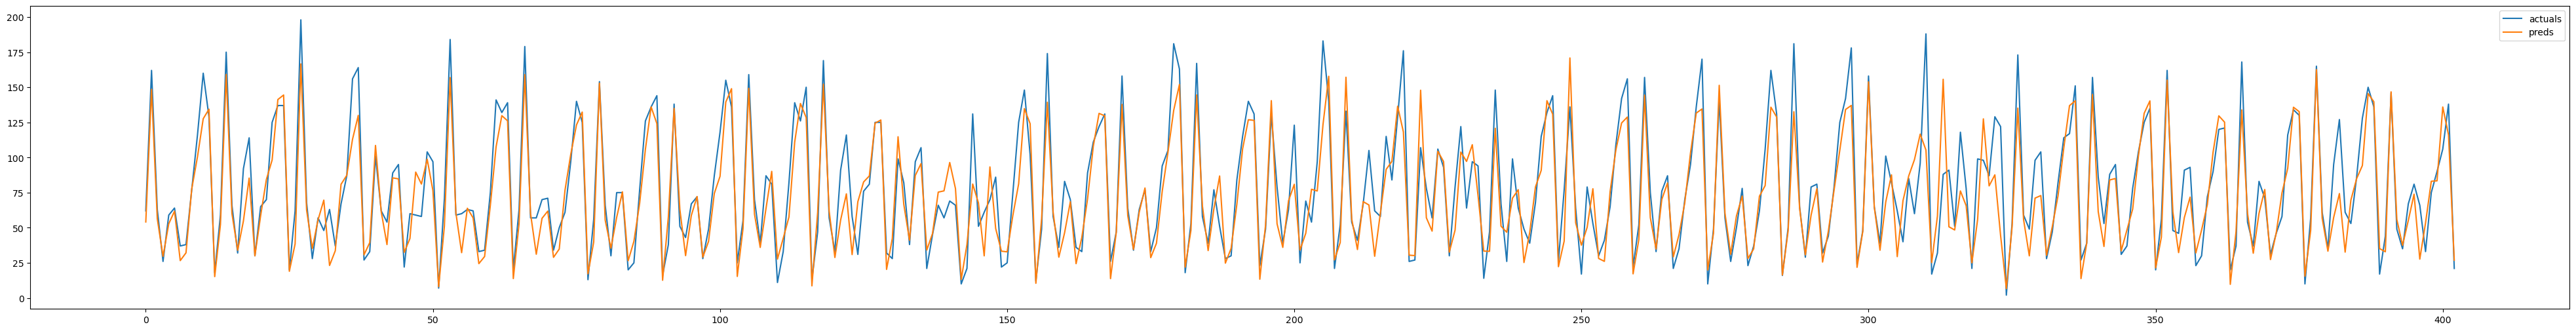

Mape:  0.21978484237129975
Rmse:  19.244831229731098
Mae:  14.1426816471753


In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 6))
plt.plot(act_dem[lookback:],label = 'actuals')
plt.plot(pred_dem,label = 'preds')
plt.legend()
plt.show()
print('Mape: ',mean_absolute_percentage_error(act_dem[lookback:],pred_dem))
print('Rmse: ',sqrt(mean_squared_error(act_dem[lookback:],pred_dem)))
print('Mae: ',mean_absolute_error(act_dem[lookback:],pred_dem))

In [38]:
#model.save('multivariate_withweather.h5')
#10 lookback,128,64,1 ,batchsize=64 ,epochs=115 till now
#mape = 21.9

In [19]:
model =load_model('multivariate_withweather.h5')